<a href="https://colab.research.google.com/github/filipoky/my_hw_ds_projects/blob/main/OverfittingHomeWork_solution2_HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [ ]:
import pandas as pd

file_id = "1-4wgz9AFXrD3tZfqHJLMhCmy4BUzAX96"
url = f"https://drive.google.com/uc?export=download&id={file_id}"

df = pd.read_csv(url)

print(df.shape)
display(df.head())


(731, 13)


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

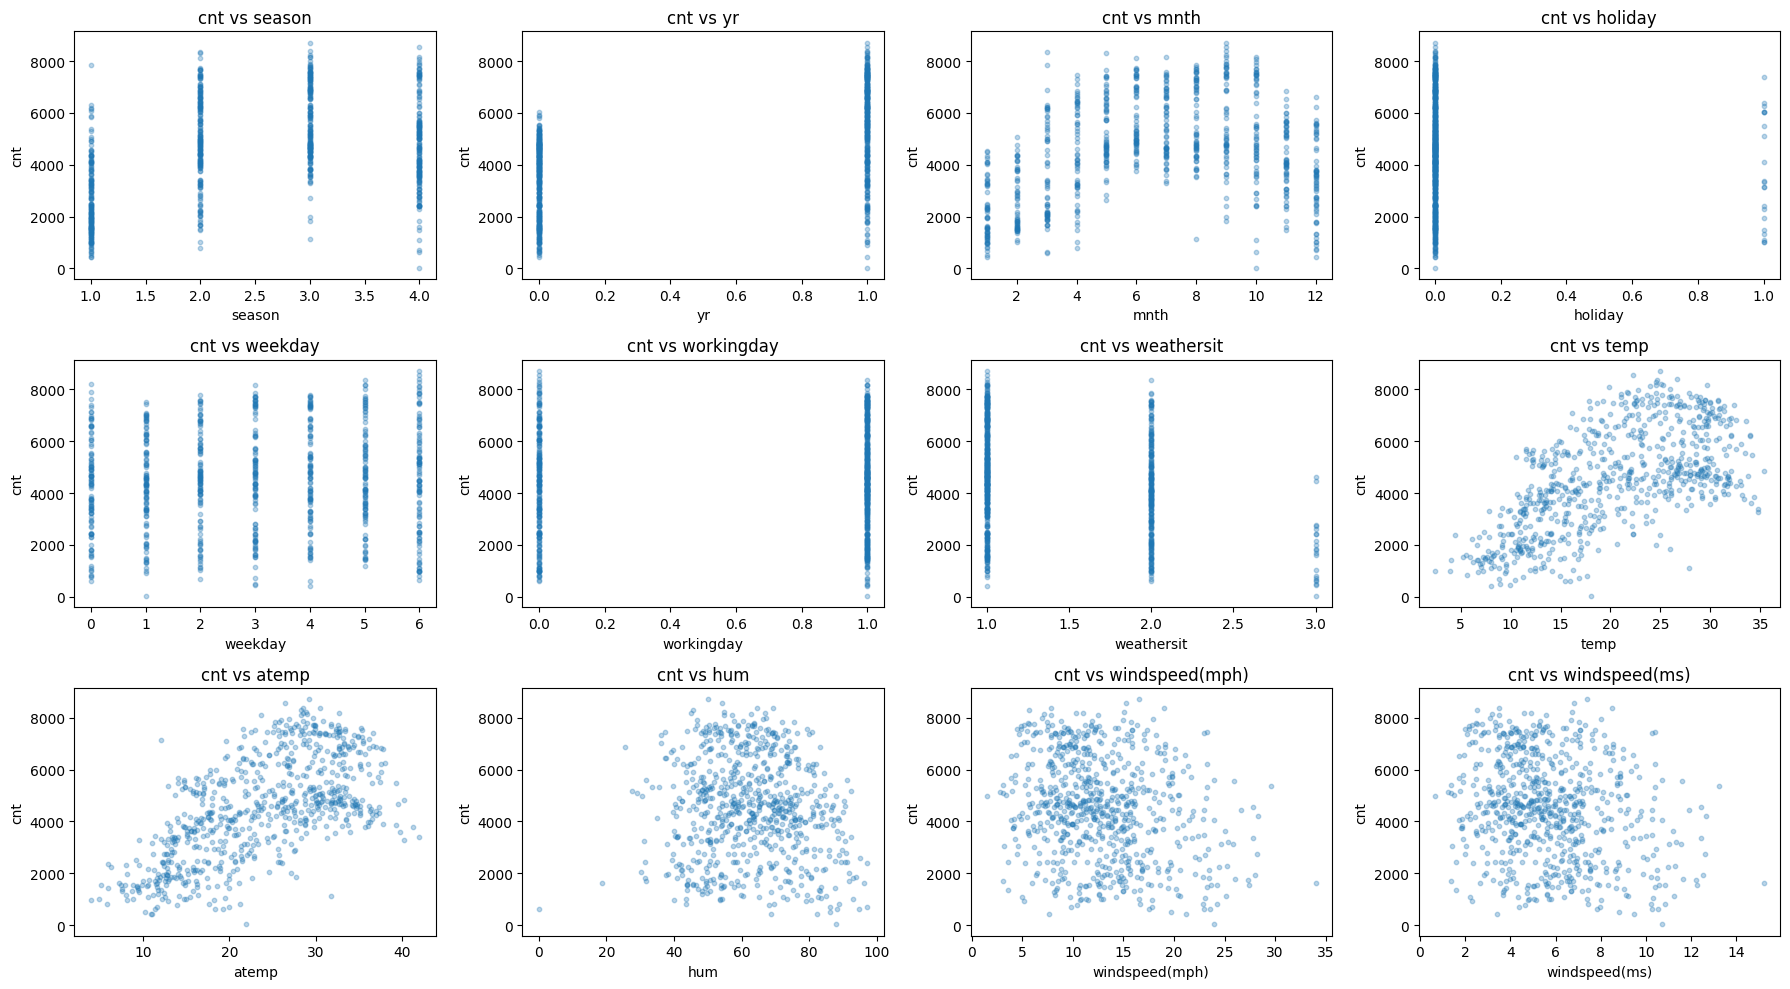

In [ ]:
import matplotlib.pyplot as plt

features = df.columns[:-1]  # всі ознаки, крім цільової cnt

plt.figure(figsize=(18, 10))
for i, col in enumerate(features, 1):
    ax = plt.subplot(3, 4, i)
    ax.scatter(df[col], df["cnt"], alpha=0.3, s=10)
    ax.set_xlabel(col)
    ax.set_ylabel("cnt")
    ax.set_title(f"cnt vs {col}")

plt.tight_layout()
plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця? -
Відповідь: Залежність кількості прокатів від місяця є нелінійною та сезонною. Кількість прокатів зростає навесні, досягає максимуму влітку та зменшується восени й узимку.
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно. - Відповідь: Кількість прокатів скоріше за все лінійно залежить від температури повітря (temp) та відчутної температури (atemp). На відповідних графіках це видно.

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [ ]:
# Кореляція всіх ознак з цільовою змінною cnt
corrs = df[df.columns[:-1]].corrwith(df["cnt"]).sort_values(ascending=False)
display(corrs)

,0
atemp,0.631066
temp,0.627494
yr,0.566710
season,0.406100
mnth,0.279977
weekday,0.067443
workingday,0.061156
holiday,-0.068348
hum,-0.100659
windspeed(mph),-0.234545


У вибірці є ознаки, що корелюють із цільовою цільовою змінною cnt, можна зробити висновок, що між ними існує близький до лінійного зв’язок, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. (За побудованими графіками та кореляційною матрицею видно, що деякі ознаки мають сильну кореляцію між собою. Це може призводити до мультиколінеарності, яка негативно впливає на стабільність коефіцієнтів лінійної регресії.) Тому доцільно проаналізувати кореляції між речовими ознаками перед побудовою моделі.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [ ]:
cols = ["temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)", "cnt"]
corr_matrix = df[cols].corr()
display(corr_matrix)

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні значення ознак.

In [ ]:
# Середні значення ознак
means = df.mean(numeric_only=True)
display(means)

,0
season,2.496580
yr,0.500684
mnth,6.519836
holiday,0.028728
weekday,2.997264
workingday,0.683995
weathersit,1.395349
temp,20.310776
atemp,23.717699
hum,62.789406


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [ ]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [ ]:
df_shuffled = shuffle(df, random_state=42)

# ЗБЕРІГАЄМО НАЗВИ ОЗНАК ДО scale()
feature_names = df_shuffled.columns[:-1]

# Масштабуємо ТІЛЬКИ значення
X = scale(df_shuffled[feature_names])
y = df_shuffled["cnt"].values


Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [ ]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [ ]:
from sklearn.linear_model import LinearRegression
import pandas as pd

reg = LinearRegression()
reg.fit(X, y)

weights = pd.Series(reg.coef_, index=df.columns[:-1]).sort_values(ascending=False)
print("Вільний член (intercept):", reg.intercept_)
display(weights)

Вільний член (intercept): 4504.354528214392


,0
windspeed(mph),1.245714e+13
yr,1.021965e+03
atemp,5.855494e+02
season,5.708638e+02
temp,3.674837e+02
weekday,1.372251e+02
workingday,5.639188e+01
holiday,-8.675934e+01
mnth,-1.413017e+02
hum,-1.456143e+02


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [ ]:
from sklearn.linear_model import Lasso
import pandas as pd

lasso = Lasso(alpha=1.0, max_iter=100000)
lasso.fit(X, y)

weights_lasso = pd.Series(lasso.coef_, index=df.columns[:-1]).sort_values(ascending=False)
print("Lasso intercept:", lasso.intercept_)
display(weights_lasso)

Lasso intercept: 4504.3488372093025


,0
yr,1.019463e+03
atemp,5.765308e+02
season,5.602416e+02
temp,3.763632e+02
weekday,1.373479e+02
workingday,5.521237e+01
windspeed(ms),-2.805140e-08
holiday,-8.615278e+01
mnth,-1.287306e+02
hum,-1.441292e+02


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [ ]:
from sklearn.linear_model import Ridge
import pandas as pd

ridge = Ridge(alpha=1.0)
ridge.fit(X, y)

weights_ridge = pd.Series(ridge.coef_, index=df.columns[:-1]).sort_values(ascending=False)
print("Ridge intercept:", ridge.intercept_)
display(weights_ridge)

Ridge intercept: 4504.3488372093025


,0
yr,1018.948379
atemp,566.347047
season,563.064572
temp,386.457889
weekday,138.005111
workingday,55.903110
holiday,-86.746098
windspeed(mph),-99.259441
windspeed(ms),-99.259441
mnth,-131.873320


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [ ]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

from sklearn.linear_model import Lasso, Ridge

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=100000)
    lasso.fit(X, y)
    coefs_lasso.append(lasso.coef_)

    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    coefs_ridge.append(ridge.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

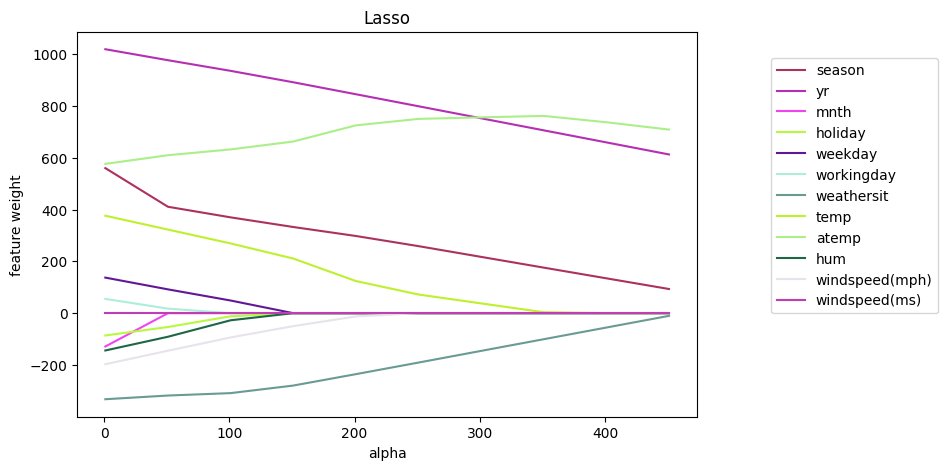

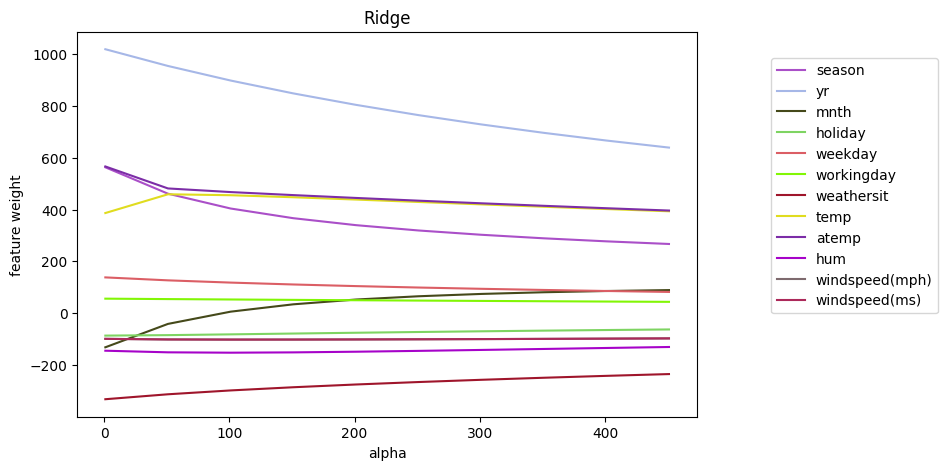

In [ ]:
plt.figure(figsize=(8, 5))

feature_names = df.columns[:-1]

for coef, feature in zip(coefs_lasso.T, feature_names):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, feature_names):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

**Відповіді:**

1) **Lasso** агресивніше зменшує ваги: воно може зробити деякі коефіцієнти рівними нулю, тоді як Ridge зазвичай лише «стискає» їх до малих значень.

2) Якщо зробити `alpha` дуже великим, **Lasso** буде прагнути занулити майже всі ваги (модель стане дуже «простою»), бо штраф L1 домінуватиме над помилкою.

3) Так, у нашому датасеті є дві майже однакові ознаки швидкості вітру (`windspeed(mph)` та `windspeed(ms)`), тому Lasso зазвичай залишає одну з них, а іншу робить близькою до нуля (або нульовою). У випадку Lasso-регресії, через L1-регуляризацію, одна з сильно корельованих ознак windspeed зазвичай занулюється вже при достатньо малих значеннях α, тобто її коефіцієнт стає меншим за 10⁻³, що означає фактичне виключення ознаки з моделі. Для Ridge-регресії таке виключення, як правило, не відбувається: навіть при зростанні α коефіцієнти зменшуються плавно, але рідко стають меншими за 10⁻³. Тобто Ridge не виключає ознаки повністю, а лише зменшує їхній вплив.

4) Для відбору неінформативних ознак доцільніше використовувати Lasso-регресію. Завдяки L1-регуляризації Lasso може повністю зануляти коефіцієнти при менш важливих або надлишкових ознаках, тим самим виключаючи їх із моделі. Це дозволяє не лише зменшити перенавчання, але й спростити модель та підвищити її інтерпретованість. Ridge-регресія, навпаки, не виконує явного відбору ознак, оскільки лише зменшує ваги, але не робить їх рівними нулю, тому вона менш придатна саме для задачі feature selection.

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [ ]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = [e[0] for e in data]
    y = [e[1] for e in data]
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

Вибране alpha_: 6


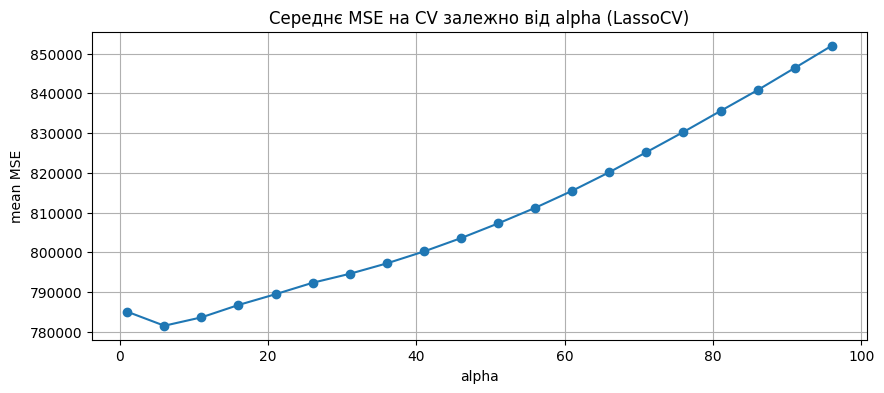

,0
yr,1.015060e+03
atemp,5.813969e+02
season,5.320190e+02
temp,3.706799e+02
weekday,1.325045e+02
workingday,5.155709e+01
windspeed(ms),-2.685470e-08
holiday,-8.329396e+01
mnth,-1.000395e+02
hum,-1.400074e+02


In [ ]:
from sklearn.linear_model import LassoCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Сітка alpha (можеш залишити так)
alphas = np.arange(1, 100, 5)

# LassoCV з крос-валідацією
regressor = LassoCV(alphas=alphas, cv=3, random_state=42, max_iter=200000)
regressor.fit(X, y)

print("Вибране alpha_:", regressor.alpha_)

# --- Середнє MSE по фолдах для кожного alpha ---
# mse_path_.shape = (n_alphas, n_folds) -> беремо середнє по фолдах
mse_mean = regressor.mse_path_.mean(axis=1)

# --- Візуалізація mean MSE залежно від alpha ---
alphas_sorted = np.array(regressor.alphas_, dtype=float)

# відсортуємо по alpha (щоб графік йшов зліва направо)
order = np.argsort(alphas_sorted)
alphas_sorted = alphas_sorted[order]
mse_mean = mse_mean[order]

plt.figure(figsize=(10,4))
plt.plot(alphas_sorted, mse_mean, marker='o')
plt.xlabel("alpha")
plt.ylabel("mean MSE")
plt.title("Середнє MSE на CV залежно від alpha (LassoCV)")
plt.grid(True)
plt.show()

# --- Коефіцієнти фінальної моделі ---
# ВАЖЛИВО: індекс = X.columns, бо саме ці ознаки використані в моделі
coef_pairs = pd.Series(regressor.coef_, index=feature_names).sort_values(ascending=False)
display(coef_pairs)




Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


alpha з мінімальним MSE для кожного фолду: [np.int64(6), np.int64(1), np.int64(51)]


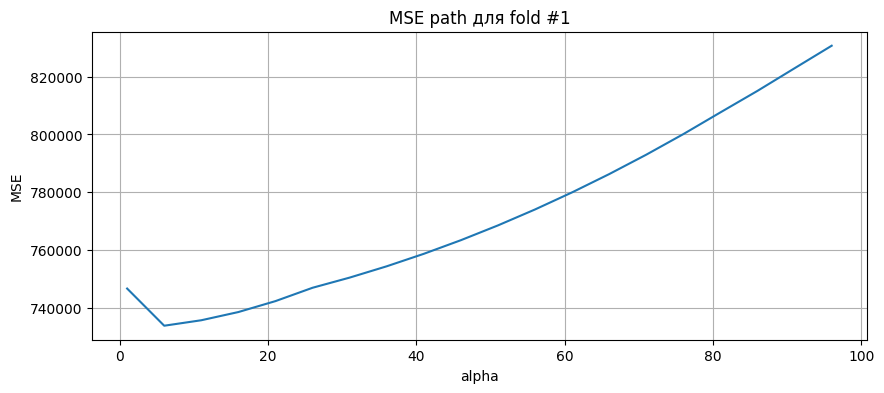

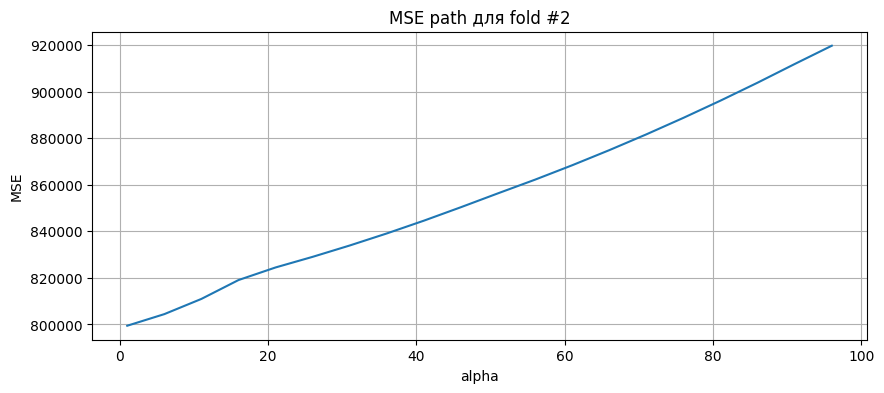

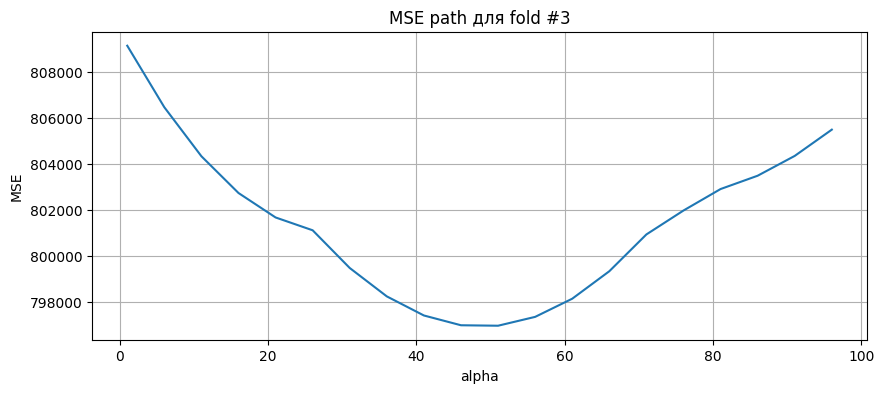

In [ ]:
import numpy as np

alphas_cv = regressor.alphas_          # (n_alphas,)
mse_path = regressor.mse_path_         # (n_alphas, n_folds)

# alpha, що мінімізує MSE для кожного фолду (стовпця)
best_alphas = []
for fold in range(mse_path.shape[1]):
    best_idx = np.argmin(mse_path[:, fold])
    best_alphas.append(alphas_cv[best_idx])

print("alpha з мінімальним MSE для кожного фолду:", best_alphas)

# Візуалізація траєкторій MSE для кожного фолду окремо
for fold in range(mse_path.shape[1]):
    data = list(zip(alphas_cv, mse_path[:, fold]))
    data = sorted(data, key=lambda t: t[0])
    create_plot(
        data=data,
        title=f"MSE path для fold #{fold+1}",
        xlabel="alpha",
        ylabel="MSE",
        figsize=(10, 4),
    )

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__
У фінальній LassoCV-моделі найбільші **позитивні** коефіцієнти отримали ознаки **yr, atemp, season, temp** (за стандартованими ознаками).
Це означає, що зі зростанням цих ознак модель прогнозує **більший** попит (`cnt`).

Логіка:
- `yr`: у 2012 році (yr=1) орендували в середньому більше, ніж у 2011 (yr=0);
- `temp`/`atemp`: тепліше → більше людей беруть велосипеди;
- `season`: у «вищих» сезонах (літо/осінь) попит вищий, ніж навесні.
На scatter-графіках це має проявлятися як тенденція до зростання `cnt` при більших значеннях цих ознак.

ТОП-4 позитивні коефіцієнти:


,0
yr,1015.060223
atemp,581.396931
season,532.018983
temp,370.679855


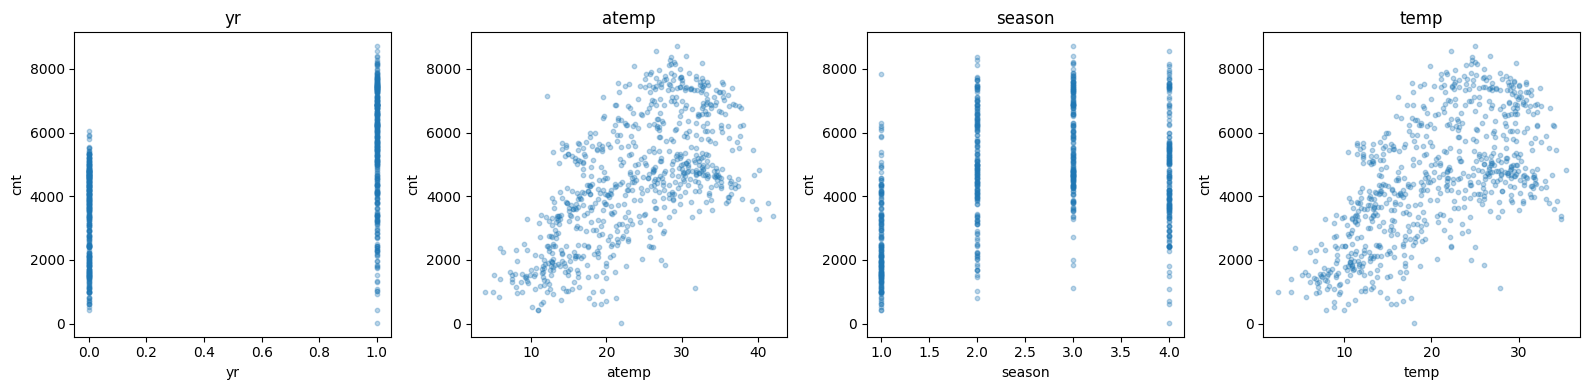

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

coef = pd.Series(regressor.coef_, index=df.columns[:-1])
top_pos = coef.sort_values(ascending=False).head(4)
print("ТОП-4 позитивні коефіцієнти:")
display(top_pos)

# Візуалізації залежності cnt від цих ознак
plt.figure(figsize=(16, 4))
for i, feat in enumerate(top_pos.index, 1):
    ax = plt.subplot(1, 4, i)
    ax.scatter(df[feat], df["cnt"], alpha=0.3, s=10)
    ax.set_xlabel(feat)
    ax.set_ylabel("cnt")
    ax.set_title(feat)
plt.tight_layout()
plt.show()

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__
Найбільші за модулем **негативні** коефіцієнти мають ознаки **weathersit, windspeed(mph), hum**.
Це означає: чим **гірша погода**, **вища вологість** і **сильніший вітер**, тим менше людей орендують велосипеди.

На графіках зазвичай видно спадання або загальну тенденцію до нижчих значень `cnt` при більших значеннях цих ознак (особливо для `weathersit` як «індексу погоди»).

ТОП-3 негативні коефіцієнти:


,0
weathersit,-330.559857
windspeed(mph),-191.771408
hum,-140.007406


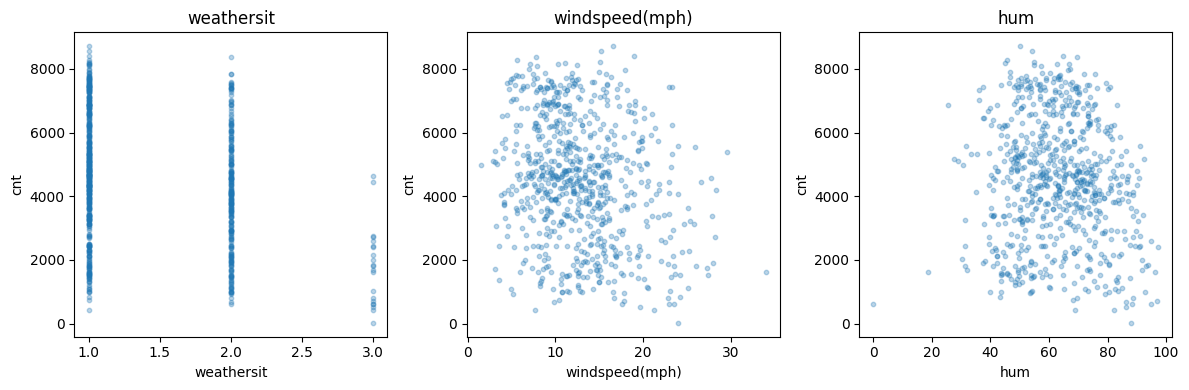

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

coef = pd.Series(regressor.coef_, index=df.columns[:-1])
top_neg = coef.sort_values().head(3)  # найменші (негативні)
print("ТОП-3 негативні коефіцієнти:")
display(top_neg)

plt.figure(figsize=(12, 4))
for i, feat in enumerate(top_neg.index, 1):
    ax = plt.subplot(1, 3, i)
    ax.scatter(df[feat], df["cnt"], alpha=0.3, s=10)
    ax.set_xlabel(feat)
    ax.set_ylabel("cnt")
    ax.set_title(feat)
plt.tight_layout()
plt.show()

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__
Коефіцієнт, близький до нуля, означає, що **зафіксована модель майже не використовує** цю ознаку для прогнозу.
У нашому випадку майже занулюється `windspeed(ms)`, бо вона дублює інформацію `windspeed(mph)` (між ними майже ідеальна лінійна залежність — це просто різні одиниці вимірювання).
Тобто «не впливає» тут означає: **в присутності дуже схожої ознаки модель обрала одну, а іншу відкинула**.

In [ ]:
import pandas as pd

coef = pd.Series(regressor.coef_, index=df.columns[:-1])
near_zero = coef[coef.abs() < 1e-3].sort_values(key=np.abs)

print("Ознаки з коефіцієнтами близькими до нуля (<1e-3):")
display(near_zero)

Ознаки з коефіцієнтами близькими до нуля (<1e-3):


,0
windspeed(ms),-2.685470e-08


### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.